# Explore US Census data



## Preliminaries

To run this notebook, you will need three things:

1. Your basic [R installation with Jupyter and the Tidyverse](https://boisestate.github.io/CS533/resources.html).
2. The `censusapi` package, which can be installed with `conda install -c mdekstrand r-censusapi`.
3. A US Census API key, which you can obtain [here](https://api.census.gov/data/key_signup.html). Sometimes data sets will require you to register to get access to them, and this is a good exampe.

You can find documentation on the `censusapi` package in the [vignette](https://cran.r-project.org/web/packages/censusapi/vignettes/getting-started.html).

For reference, see [R for Data Science Chapter 5](r4ds.had.co.nz/transform.html) and the [dplyr introduction](dplyr.tidyverse.org/articles/dplyr.html).

In [1]:
library(tidyverse)
library(censusapi)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Warning message:
“package ‘censusapi’ was built under R version 3.4.1”
Attaching package: ‘censusapi’

The following object is masked from ‘package:methods’:

    getFunction



Set up your census key:

In [2]:
Sys.setenv(CENSUS_KEY="768b29b90e34f0857a4800cf2db22919673967e9")

## Loading Census Data

The census data is scattered among a bunch of sources.  Accessing it is somewhat arcane.

- The `sf1` data set is the _summary file_, containing summary statistics about each region in the _decennial census_.
- The `vintage` says we want to use the 2010 census (the most recent one).
- `vars` selects some variables to download; `NAME` is the name of the region, `P0010001` is the total population, and `P0420002` is the total institutionalized (imprisoned) population.  For more fun, see the [full list of variables](http://api.census.gov/data/2010/sf1/variables.html).

In [3]:
last_census = getCensus(name="sf1", vintage=2010, vars=c("NAME", "P0010001", "P0420002", "P0420003", "P0420004"), region="state:*")
head(last_census)

NAME,state,P0010001,P0420002,P0420003,P0420004
Alabama,01,4779736,67004,41177,1768
Alaska,02,710231,6458,4206,515
Arizona,04,6392017,84788,67767,2347
Arkansas,05,2915918,47287,25844,2176
California,06,37253956,397142,256807,18610
Colorado,08,5029196,61591,40568,2645


I recommend that you rename the fields to be something more meaningful before proceeding!

In [4]:
last_census = rename(last_census, total = P0010001, institutionalized = P0420002, adult_prisons = P0420003, juvenile_detention = P0420004)

### Most Populus States

What 5 states have the highest population?

**California, Texas, New York, Florida, Illinois**

In [5]:
arrange(last_census, desc(total)) %>%
head(n=5)

NAME,state,total,institutionalized,adult_prisons,juvenile_detention
California,06,37253956,397142,256807,18610
Texas,48,25145561,375392,267405,9908
New York,36,19378102,231163,95306,9149
Florida,12,18801310,254506,167453,10061
Illinois,17,12830632,159989,70828,4282


### Highest Prison Populations

What 5 states have the highest prison populations?

**Texas, California, Florida, Georgia, Pennsylvania**

In [6]:
last_census = mutate(last_census, prisons = adult_prisons + juvenile_detention)
head(arrange(last_census, desc(prisons)), n=5)

NAME,state,total,institutionalized,adult_prisons,juvenile_detention,prisons
Texas,48,25145561,375392,267405,9908,277313
California,06,37253956,397142,256807,18610,275417
Florida,12,18801310,254506,167453,10061,177514
Georgia,13,9687653,144545,104012,3967,107979
Pennsylvania,42,12702379,197112,97820,8840,106660


### Prisoners per Capita

What 5 states have the most prisoners per capita?

**Louisiana, Mississippi, Oklahoma, Georgia, Texas**

In [7]:
last_census = mutate(last_census, prisons_per_capita = prisons/total)
head(arrange(last_census, desc(prisons_per_capita)), n=5)

NAME,state,total,institutionalized,adult_prisons,juvenile_detention,prisons,prisons_per_capita
Louisiana,22,4533372,88104,60804,1453,62257,0.01373304
Mississippi,28,2967297,55135,34273,2247,36520,0.01230750
Oklahoma,40,3751351,64411,40562,1551,42113,0.01122609
Georgia,13,9687653,144545,104012,3967,107979,0.01114604
Texas,48,25145561,375392,267405,9908,277313,0.01102831


### Probability

What is the probability that a person selected at random is born in Rhode Island?

**0.003368523**

In [8]:
total = summarise(last_census, sum_total = sum(total))['sum_total']
RI = filter(last_census, NAME == 'Rhode Island')['total']
(prob = RI/total)

total
0.003368523


What is the probability that a person is born in one of the Dakotas (North Dakota or South Dakota)?

**0.004758104**

In [9]:
vars <- c("North Dakota", "South Dakota")
filter(last_census, NAME %in% vars ) %>%
    summarise(sum = sum(total)) / total

sum
0.004758104


## Visualization

Plot a histogram of state populations.

In [10]:
library(ggplot2)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


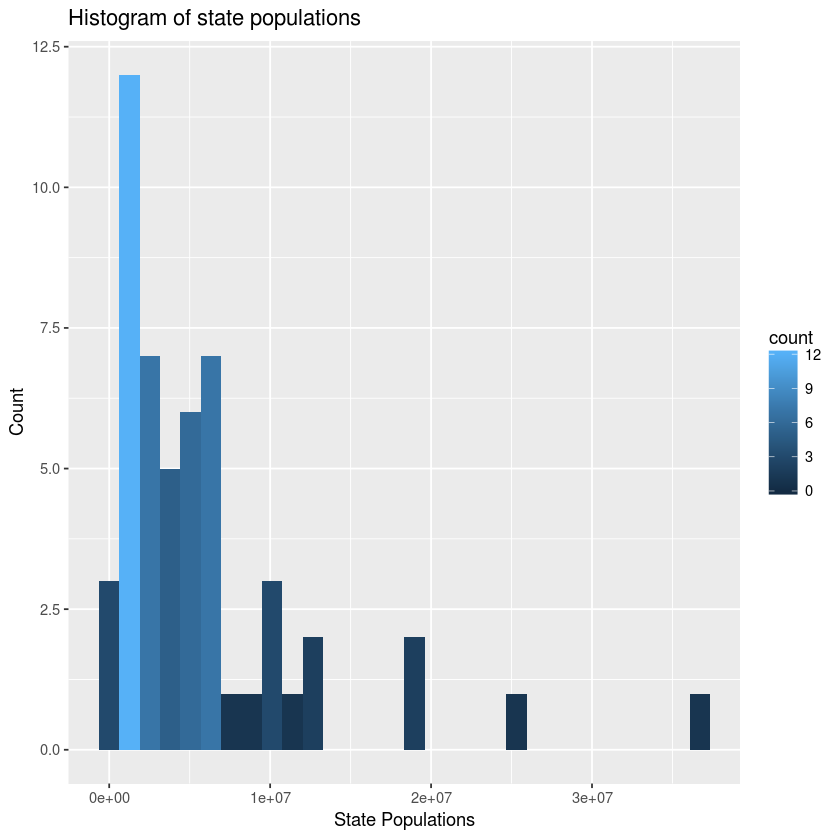

In [11]:
ggplot(data=last_census, aes(last_census$total)) +
  geom_histogram(aes(fill=..count..)) +
  labs(title="Histogram of state populations") +
  labs(x="State Populations", y="Count")

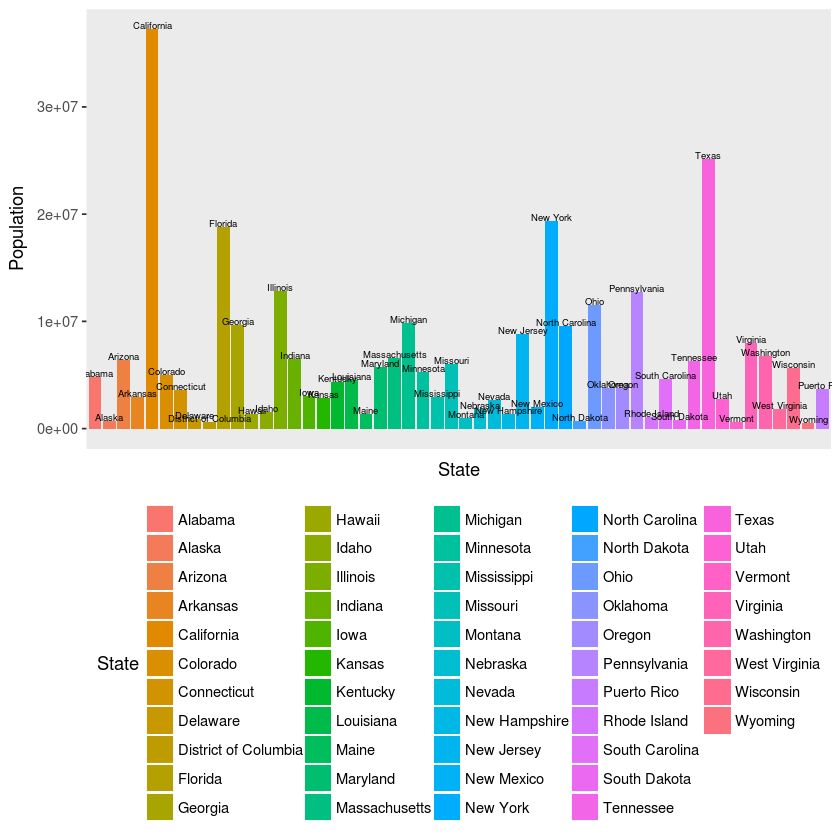

In [12]:
ggplot(data=last_census, aes(x=state, y=total, fill=NAME)) +
  geom_bar(stat="identity")+
  geom_text(aes(label=NAME), vjust=0, color="black", size=2)+
  theme(legend.position="bottom",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.grid.major = element_blank(),panel.grid.minor = element_blank()) +
  labs(x = "State", y = "Population", fill = "State")

Plot a histogram of _county_ populations.  You can get counties by using `county:*` as your selector instead of `state:*` in a `getCensus` call.

In [13]:
last_census_county = getCensus(name="sf1", vintage=2010, vars=c("NAME", "P0010001"), region="county:*")
head(last_census_county)

NAME,state,county,P0010001
Autauga County,01,001,54571
Baldwin County,01,003,182265
Barbour County,01,005,27457
Bibb County,01,007,22915
Blount County,01,009,57322
Bullock County,01,011,10914


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


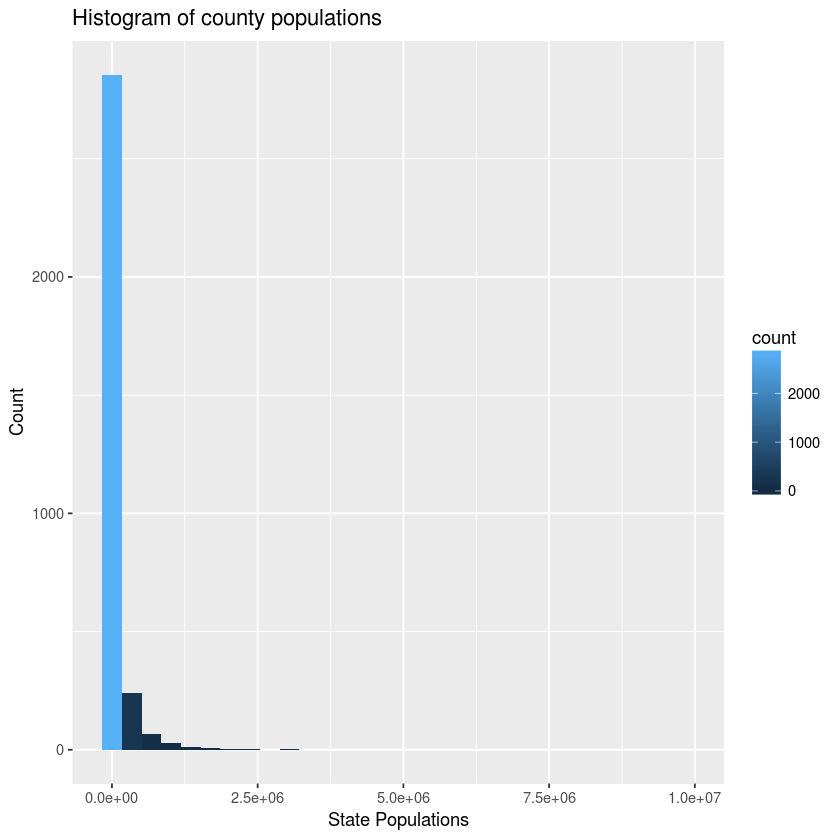

In [14]:
ggplot(data=last_census_county, aes(last_census_county$P0010001)) +
  geom_histogram(aes(fill=..count..)) +
  labs(title="Histogram of county populations") +
  labs(x="State Populations", y="Count")

What are the largest 5 counties in Idaho?

**Ada Country, Canyon County, Kootenai County, Bonneville County, Bannock County**

In [15]:
idaho_code = filter(last_census, NAME == 'Idaho')$state
filter(last_census_county, state == idaho_code) %>%
    arrange(desc(P0010001)) %>%
    head(n=5)

NAME,state,county,P0010001
Ada County,16,001,392365
Canyon County,16,027,188923
Kootenai County,16,055,138494
Bonneville County,16,019,104234
Bannock County,16,005,82839


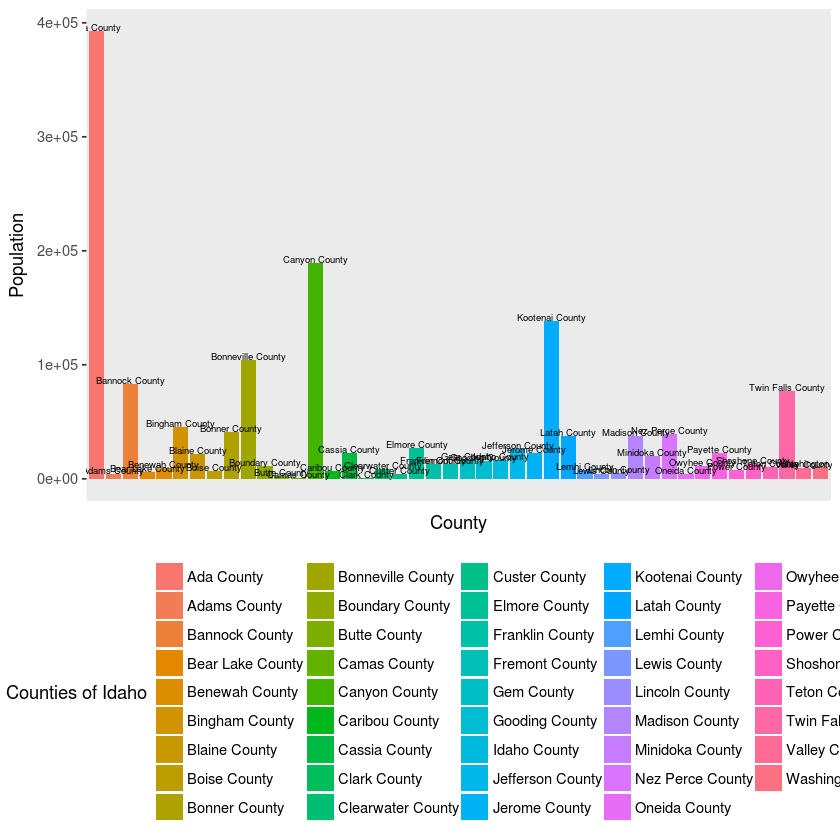

In [16]:
idaho_census = filter(last_census_county, state == idaho_code)
ggplot(data=idaho_census, aes(x=county, y=P0010001, fill=NAME)) +
  geom_bar(stat="identity")+
  geom_text(aes(label=NAME), vjust=0, color="black", size=2)+
  theme(legend.position="bottom",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.grid.major = element_blank(),panel.grid.minor = element_blank()) +
  labs(x = "County", y = "Population", fill = "Counties of Idaho")

## Joining Data

For the next section, we want to work with _two_ data sets.

Fetch the 2000 data set as well. Unfortunately, they changed the variable names!  You can find the 2000 list [here](http://api.census.gov/data/2000/sf1/variables.html); the key thing is that, for example, the total population variable is now `P001001`

In [17]:
census2000 = getCensus(name="sf1", vintage=2000, vars=c("NAME", "P001001"), region="state:*")
head(census2000)
census2010 = getCensus(name="sf1", vintage=2010, vars=c("NAME", "P0010001"), region="state:*")
head(census2010)

NAME,state,P001001
Alabama,01,4447100
Alaska,02,626932
Arizona,04,5130632
Arkansas,05,2673400
California,06,33871648
Colorado,08,4301261


NAME,state,P0010001
Alabama,01,4779736
Alaska,02,710231
Arizona,04,6392017
Arkansas,05,2915918
California,06,37253956
Colorado,08,5029196


You will need to connect the two data sets; the `inner_join` dplyr verb is used for this.

In [18]:
joined_census <- census2000 %>% 
  inner_join(census2010) %>% 
  rename(P2000=P001001,P2010=P0010001)

Joining, by = c("NAME", "state")


### Population Growth

What 5 states saw the most population growth from 2000 to 2010?

**Texas, California, Florida, Georgia, North Carolina**

In [19]:
joined_census %>% 
  mutate(P_Growth = P2010 - P2000) %>%
  arrange(desc(P_Growth)) %>%
  head(n=5)

NAME,state,P2000,P2010,P_Growth
Texas,48,20851820,25145561,4293741
California,06,33871648,37253956,3382308
Florida,12,15982378,18801310,2818932
Georgia,13,8186453,9687653,1501200
North Carolina,37,8049313,9535483,1486170


### Population Loss

What 5 states saw the most population loss from 2000 to 2010?

**Michigan, Rhode Island, Vermont, District of Columbia, North Dakota. Only first state has population loss, others are negative loss.**

In [20]:
joined_census %>% 
  mutate(P_Loss = P2000 - P2010) %>%
  arrange(desc(P_Loss)) %>%
  head(n=5)

NAME,state,P2000,P2010,P_Loss
Michigan,26,9938444,9883640,54804
Rhode Island,44,1048319,1052567,-4248
Vermont,50,608827,625741,-16914
District of Columbia,11,572059,601723,-29664
North Dakota,38,642200,672591,-30391


### Fancy Graphics

See [Mapping US State, County, and Zipcode Data with R](http://www.poppy-zhang.com/r-coding/mapping-us-state-county-and-zipcode-data-with-r/) and plot a map of the 48 contiguous US states, shaded by their population growth from 2000 to 2010.

In [21]:
library(ggmap)
library(ggplot2)
# library(zipcode)
# library("choroplethrMaps")
# library("choroplethr")

In [22]:
states_map <- map_data("state")


Attaching package: ‘maps’

The following object is masked from ‘package:purrr’:

    map



In [23]:
state_growth <- joined_census %>% 
  mutate(P_Growth = P2010 - P2000) %>%
  mutate(state = tolower(NAME)) %>%
  select(-one_of(c('NAME','P2000','P2010')))

In [24]:
head(state_growth)

state,P_Growth
alabama,332636
alaska,83299
arizona,1261385
arkansas,242518
california,3382308
colorado,727935


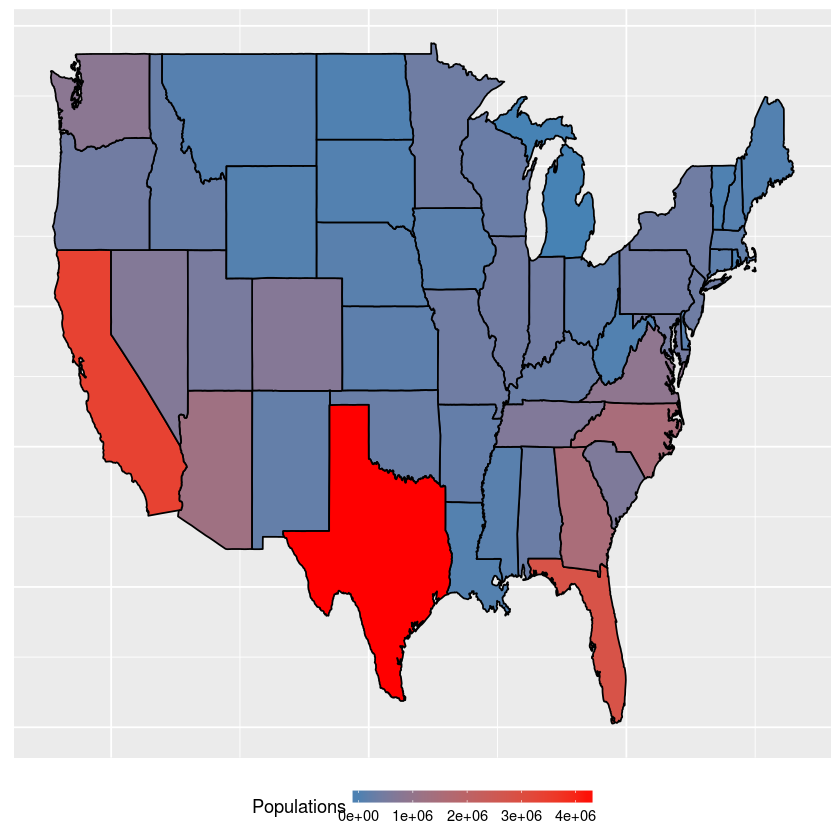

In [25]:
ggplot(state_growth, aes(map_id = state)) +
 geom_map(aes(fill = P_Growth), map = states_map, color ="black") +
 expand_limits(x = states_map$long, y = states_map$lat) +
 theme(legend.position = "bottom",
 axis.ticks = element_blank(),
 axis.title = element_blank(),
 axis.text = element_blank()) +
 scale_fill_gradient(low="steelblue", high="red") +
 guides(fill = guide_colorbar(barwidth = 10, barheight = .5)) +
 labs(fill = "Populations")

## What 10 states have the most house units growth from 2000 to 2010?
**Texas, Florida,
California, Georgia, North Carolina, Arizona, Virginia, Washington, New York, Illinois**

In [26]:
house2000 <- getCensus(name="sf1", vintage=2000, vars=c("NAME", "H001001"), region="state:*") %>%
rename(TotalUnits2000=H001001)
head(house2000)
house2010 = getCensus(name="sf1", vintage=2010, vars=c("NAME", "H00010001"), region="state:*") %>%
rename(TotalUnits2010=H00010001)
head(house2010)

NAME,state,TotalUnits2000
Alabama,01,1963711
Alaska,02,260978
Arizona,04,2189189
Arkansas,05,1173043
California,06,12214549
Colorado,08,1808037


NAME,state,TotalUnits2010
Alabama,01,2171853
Alaska,02,306967
Arizona,04,2844526
Arkansas,05,1316299
California,06,13680081
Colorado,08,2212898


In [27]:
house2000 %>% 
    inner_join(house2010) %>%
    mutate(H_Growth=TotalUnits2010-TotalUnits2000) %>%
    arrange(desc(H_Growth)) %>%
    head(n=10)

Joining, by = c("NAME", "state")


NAME,state,TotalUnits2000,TotalUnits2010,H_Growth
Texas,48,8157575,9977436,1819861
Florida,12,7302947,8989580,1686633
California,06,12214549,13680081,1465532
Georgia,13,3281737,4088801,807064
North Carolina,37,3523944,4327528,803584
Arizona,04,2189189,2844526,655337
Virginia,51,2904192,3364939,460747
Washington,53,2451075,2885677,434602
New York,36,7679307,8108103,428796
Illinois,17,4885615,5296715,411100


## What 10 states do have the largest mean house units of county in 2010?
**District of Columbia, California, Massachusetts,Arizona, Connecticut, New Jersey,Delaware, Florida, New York, Hawaii**

In [28]:
houseByCounty2010 = getCensus(name="sf1", vintage=2010, vars=c("NAME", "H00010001"), region="county:*")
head(houseByCounty2010)

NAME,state,county,H00010001
Autauga County,01,001,22135
Baldwin County,01,003,104061
Barbour County,01,005,11829
Bibb County,01,007,8981
Blount County,01,009,23887
Bullock County,01,011,4493


In [29]:
houseByCounty2010 %>% 
    rename(CountyName=NAME) %>%
    inner_join(house2010) %>% 
    rename(StateName=NAME) %>%
    group_by(StateName, state) %>%
    summarise(
        avg_house_units = mean(H00010001)) %>%
    arrange(desc(avg_house_units)) %>%
    head(n=10)

Joining, by = "state"


StateName,state,avg_house_units
District of Columbia,11,296719.0
California,06,235863.5
Massachusetts,25,200589.6
Arizona,04,189635.1
Connecticut,09,185986.4
New Jersey,34,169217.2
Delaware,10,135295.0
Florida,12,134172.8
New York,36,130775.9
Hawaii,15,103901.6


## What is the growth of vacant house units in Idaho from 2000 to 2010?
**30209**

In [30]:
vacant2000 = getCensus(name="sf1", vintage=2000, vars=c("NAME", "H005001"), region="state:*") %>%
    filter(NAME=="Idaho")
head(vacant2000)
vacant2010 = getCensus(name="sf1", vintage=2010, vars=c("NAME", "H0050001"), region="state:*") %>%
    filter(NAME=="Idaho")
head(vacant2010)

NAME,state,H005001
Idaho,16,58179


NAME,state,H0050001
Idaho,16,88388


In [31]:
vacant2000 %>% 
    inner_join(vacant2010) %>%
    mutate(vacant_house_growth=H0050001-H005001)

Joining, by = c("NAME", "state")


NAME,state,H005001,H0050001,vacant_house_growth
Idaho,16,58179,88388,30209


## What is the average growth of vacant house units for sale or rent for each 10 years in Idaho from 1990 to 2010?
**For Rent: 3938.5, For Sale: 3807.5**

In [32]:
vacantByType1990 = getCensus(name="sf1", vintage=1990, vars=c("H0050001", "H0050002"), region="state:*") %>%
    filter(state==16) %>%
    rename(Rent1990=H0050001,Sale1990=H0050002) %>%
    mutate(NAME="Idaho") %>%
    select(NAME, state, Rent1990, Sale1990)
head(vacantByType1990)
vacantByType2000 = getCensus(name="sf1", vintage=2000, vars=c("NAME", "H005002", "H005003"), region="state:*") %>%
    filter(NAME=="Idaho") %>%
    rename(Rent2000=H005002,Sale2000=H005003)
head(vacantByType2000)
vacantByType2010 = getCensus(name="sf1", vintage=2010, vars=c("NAME", "H0050002", "H0050004"), region="state:*") %>%
    filter(NAME=="Idaho") %>%
    rename(Rent2010=H0050002,Sale2010=H0050004)
head(vacantByType2010)

NAME,state,Rent1990,Sale1990
Idaho,16,8483,5199


NAME,state,Rent2000,Sale2000
Idaho,16,10656,7682


NAME,state,Rent2010,Sale2010
Idaho,16,16360,12814


In [33]:
vacantByType1990 %>%
    inner_join(vacantByType2000) %>%
    inner_join(vacantByType2010) %>% 
    transmute(State=NAME, Rent_Growth1=Rent2000-Rent1990, Rent_Growth2=Rent2010-Rent2000,
              Sale_Growth1=Sale2000-Sale1990, Sale_Growth2=Sale2010-Sale2000) %>%
    mutate(meanOfRentDecadeGrowth=(Rent_Growth1 + Rent_Growth2)/2, meanOfSaleDecadeGrowth=(Sale_Growth1 + Sale_Growth2)/2)

Joining, by = c("NAME", "state")
Joining, by = c("NAME", "state")


State,Rent_Growth1,Rent_Growth2,Sale_Growth1,Sale_Growth2,meanOfRentDecadeGrowth,meanOfSaleDecadeGrowth
Idaho,2173,5704,2483,5132,3938.5,3807.5


## What are top 3 counties in Idaho which have the largest growth of vacant house units for sale or for rent from 2000 to 2010?
**For Sale: Ada County, Canyon County, Kootenai County, For Rent: Ada County, Canyon County, Bonneville County**

In [34]:
vacantByTypeCounty2000 = getCensus(name="sf1", vintage=2000, vars=c("NAME", "H005002", "H005003"), region="county:*") %>%
    filter(state==16) %>%
    rename(Rent2000=H005002,Sale2000=H005003)
head(vacantByTypeCounty2000)
vacantByTypeCounty2010 = getCensus(name="sf1", vintage=2010, vars=c("NAME", "H0050002", "H0050004"), region="county:*") %>%
    filter(state==16) %>%
    rename(Rent2010=H0050002,Sale2010=H0050004)
head(vacantByTypeCounty2010)

NAME,state,county,Rent2000,Sale2000
Ada County,16,001,1772,1488
Adams County,16,003,64,41
Bannock County,16,005,728,413
Bear Lake County,16,007,56,55
Benewah County,16,009,69,52
Bingham County,16,011,285,182


NAME,state,county,Rent2010,Sale2010
Ada County,16,001,4038,3284
Adams County,16,003,51,47
Bannock County,16,005,864,501
Bear Lake County,16,007,81,92
Benewah County,16,009,70,66
Bingham County,16,011,291,174


In [35]:
vacantByTypeCounty2000 %>%
    inner_join(vacantByTypeCounty2010) %>%
    mutate(RentGrowth=Rent2010-Rent2000, SaleGrowth=Sale2010-Sale2000) %>%
    arrange(desc(RentGrowth)) %>%
    head(5)

Joining, by = c("NAME", "state", "county")


NAME,state,county,Rent2000,Sale2000,Rent2010,Sale2010,RentGrowth,SaleGrowth
Ada County,16,001,1772,1488,4038,3284,2266,1796
Canyon County,16,027,892,840,1840,1869,948,1029
Bonneville County,16,019,453,350,1073,697,620,347
Kootenai County,16,055,896,703,1326,1283,430,580
Blaine County,16,013,382,110,642,432,260,322


In [36]:
vacantByTypeCounty2000 %>%
    inner_join(vacantByTypeCounty2010) %>%
    mutate(RentGrowth=Rent2010-Rent2000, SaleGrowth=Sale2010-Sale2000) %>%
    arrange(desc(SaleGrowth)) %>%
    head(5)

Joining, by = c("NAME", "state", "county")


NAME,state,county,Rent2000,Sale2000,Rent2010,Sale2010,RentGrowth,SaleGrowth
Ada County,16,001,1772,1488,4038,3284,2266,1796
Canyon County,16,027,892,840,1840,1869,948,1029
Kootenai County,16,055,896,703,1326,1283,430,580
Bonneville County,16,019,453,350,1073,697,620,347
Blaine County,16,013,382,110,642,432,260,322
